In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import math
import scipy.integrate
import pandas as pd
import seaborn as sb
import sys
sys.path.insert(0, '..')
import cylinder.surfaces_and_fields.system_cylinder as cylinder

firsttime=False

plt.rcParams["figure.figsize"]=10,10
plt.rcParams['font.size'] = '18'

# 1. Limits perturbatively

Plot the linear limit of stability $k_c(\gamma, \kappa)$ obtained from linear stability analysis.

The energy difference is $$ \frac{\Delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 r_0^2 -1)+ \frac{\kappa}{8r_0^2} (3 + (4\tilde{H}_0-1) k^2r_0^2 + 2 k^4 r_0^4), $$ setting $r_0 =1$
$$ \frac{\Delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 -1)+ \frac{\kappa}{8} (3 + (4\tilde{H}_0-1) k^2 + 2 k^4). $$

$\tilde{H}_0=H_0r_0$

Solutions are at $$ k_c(g) = \frac{1}{2} \sqrt{1-2g-4h + \sqrt{8(2g-3)+(-1+4h+2g)^2}} $$ with scaled and effective surface tension $g=\gamma/\kappa - \frac{1}{2}\tilde{H}_0^2$.

In case of zero spontaneous curvature $h=0$:

$$ k_c(g) = \frac{1}{2} \sqrt{1-2g + \sqrt{8(2g-3)+(-1+2g)^2}}. $$

In [37]:
def kcrit_old(g,h):
    """
    Here, H_0 was defined to be a preferred mean instead of total curvature;
    the term was (2H-2H_0) instead of (2H-H_0).  So this gives results compressed
    by 1/2 on the H_0 axis, for example critical preffered curvature H_0=-1/2 instead of -1.
    And H_0^2 was taken out as an effective surface tension instead of (-1/r_0-H_0)^2,
    although this makes no difference to final result.
    """
    g+=2*h**2
    #discriminant1_alt =-23 -16*h+ 12* g+64*h**2+ + 32 * g*h+4 * g**2
    discriminant1 =8*(2*g-3)+(-1+8*h+2*g)**2
    #print(discriminant1,discriminant1_alt )
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-8*h + math.sqrt(discriminant1)
        #print(discriminant2, math.sqrt(discriminant1), 1-8*h + math.sqrt(discriminant1), 2*g)
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2)

def kcrit(g,h=0):
    g+=1/2*h**2
    discriminant1 =8*(2*g-3)+(-1+4*h+2*g)**2
    #print(discriminant1,discriminant1_alt )
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-4*h + math.sqrt(discriminant1)
        #print(discriminant2, math.sqrt(discriminant1), 1-8*h + math.sqrt(discriminant1), 2*g)
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2) 

def kcrit_alt(g,h=0):
    """ taking out kappa/2(2H-H_0)^2 as part of effective surface tension
    """
    g+=1/2*(-1-h)**2
    discriminant1 = -7 + 2*g +g**2 -6*h +2*g*h +h**2
    #print(discriminant1,discriminant1_alt )
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-g-h + math.sqrt(discriminant1)
        discriminant2/=2
        #print(discriminant2, math.sqrt(discriminant1), 1-8*h + math.sqrt(discriminant1), 2*g)
        if discriminant2 <0:
            return np.nan
        else:
            return math.sqrt(discriminant2)

In [39]:
def kcrit_second_old(g,h):
    g+=2*h**2
    discriminant1 =8*(2*g-3)+(-1+8*h+2*g)**2
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-8*h - math.sqrt(discriminant1) #note (-)
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2)
        
def kcrit_second(g,h=0):
    g+=1/2*(-1-h)**2
    discriminant1 = -7 + 2*g +g**2 -6*h +2*g*h +h**2
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-g-h - math.sqrt(discriminant1) #note (-)
        discriminant2/=2
        if discriminant2 <0:
            return np.nan
        else:
            return math.sqrt(discriminant2)

In [40]:
gs = list(np.arange(0.001, 10, .001))
gs.extend([1/kappa for kappa in range(1,10)])
gs.extend( [20,50,100,200,500,1000,10000,100000])
gs.sort()
kcrits_ = [kcrit(g, h=0) for g in gs] #generate data

Plot of limit of instability as a function of rising relative surface tension $\gamma$:

(0.0, 4.0)

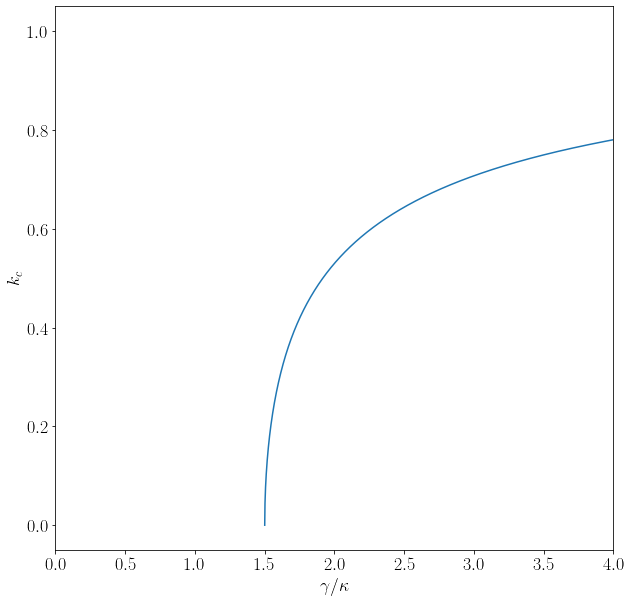

In [41]:
plt.plot([g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim(0,4)

Same limit viewed as a function of relative bending rigidity $\kappa$:

(0.0, 1.0)

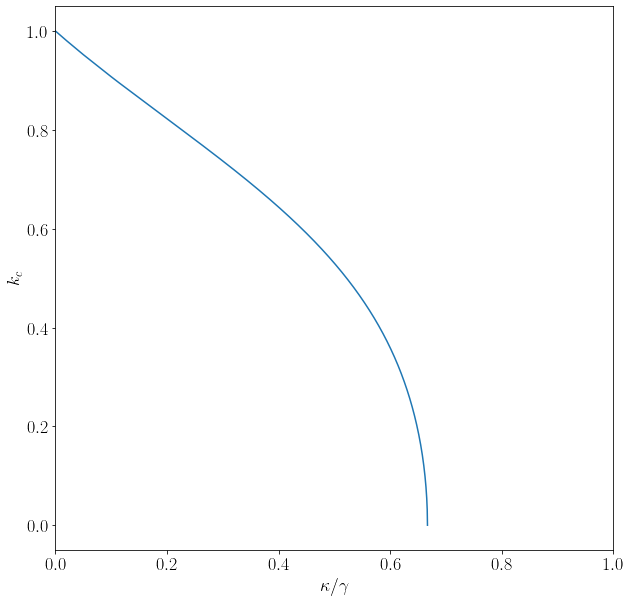

In [42]:
plt.plot([1/g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim(0,1)

## 1.2 With Spontaneous curvature

Now try limits of instability with nonzero spontaneous curvatures

(0.0, 10.0)

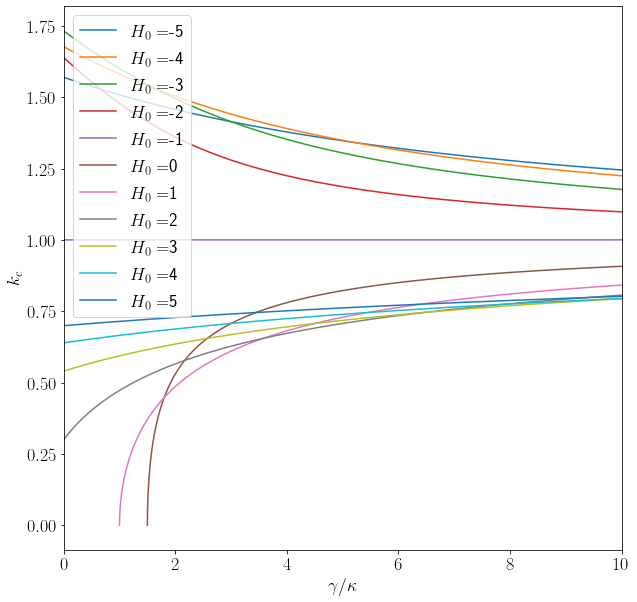

In [43]:
hs = np.arange(-5, 6, 1)
kcrits_h = {} #dict to save all the data
for h in hs:
    kcrits_h[h] = [kcrit(g, h=h) for g in gs]
    plt.plot([g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim((0,10))

At positive spontaneous curvature $H_0$, the instability is supresses, with longer cylinders (smaller wavenumber $k$) than $k=1$ remaining stable.   Critical bending rigidity remains at the same point $\kappa/\gamma = 3/2$.

At negative spontanous curvatures the cylinder is destablized.

In a $\gamma/\kappa$ view:

(0.0, 1.0)

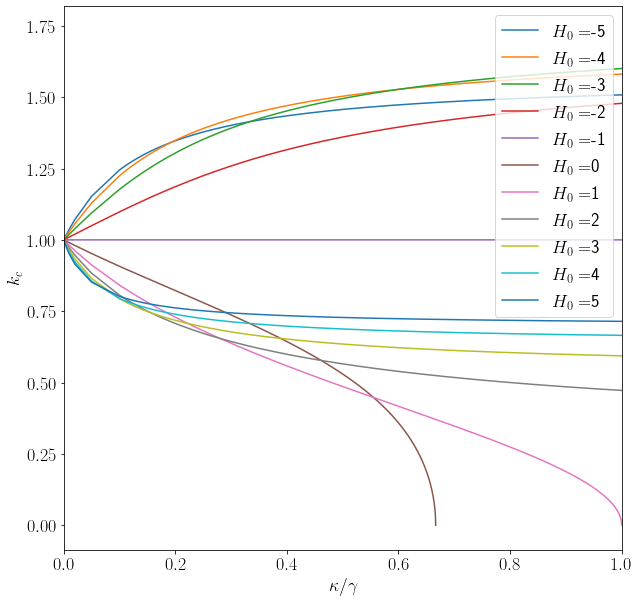

In [44]:
for h in hs:
    plt.plot([1/g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim((0,1))

Now plot from the angle of varying $H_0$ at some fixed $\gamma/\kappa$

Text(0.5, 0, '$H_0$')

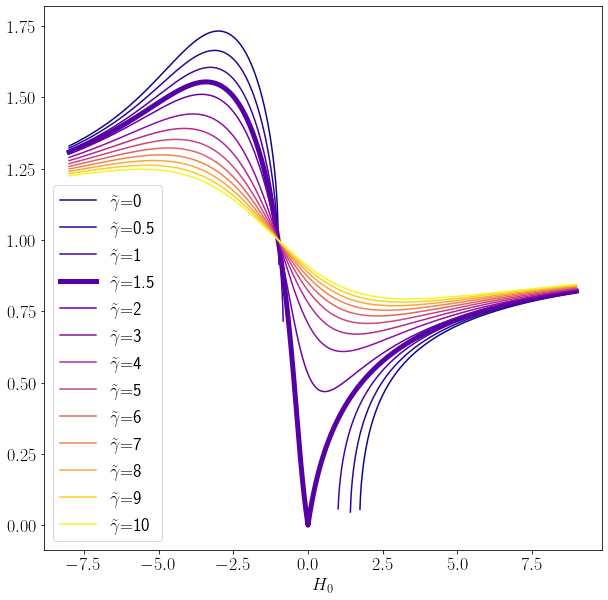

In [45]:
fine_hs = np.arange(-8, 9, .01)
g_ratios = [i for i in np.arange(0,11,1)]
g_ratios.extend([.5,1.5])
g_ratios.sort()
kcrits_rangehs= {} #place to store data
#colorcode
g_ratio_colors = {} 
for g_ratio in g_ratios:
    value=(g_ratio-min(g_ratios))/(max(g_ratios)-min(g_ratios))
    g_ratio_colors[g_ratio]= plt.cm.plasma(value)
    
#plot
plt.figure(figsize=(10,10))    
for g_ratio in g_ratios:
    kcrits_rangehs[g_ratio] = [kcrit(g_ratio,h) for h in fine_hs] #generate data
    if g_ratio == 1.5: #bold the line at critical bending rigidity     
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                linewidth=5, c=g_ratio_colors[g_ratio])
    else:
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                 c=g_ratio_colors[g_ratio])
plt.legend()
plt.xlabel(r"$H_0$")
#plt.ylim(0,2)

The interesting case at zero surface tension

Text(0.5, 0, '$H_0$')

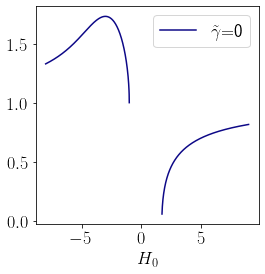

In [11]:
g_ratio =0
plt.figure(figsize=(4,4))  
kcrits_rangehs[g_ratio] = [kcrit(g_ratio,h) for h in fine_hs] #generate data
plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                 c=g_ratio_colors[g_ratio])
plt.legend()
plt.xlabel(r"$H_0$")
#plt.ylim(0,2)

It actually has second solutions of $k_c = \pm \sqrt { ... \pm \sqrt{...} } $ for a ragion around H0=-1:


In [12]:
def kcrit_secondsolution(g,h):
    g+=2*h**2
    discriminant1 =8*(2*g-3)+(-1+8*h+2*g)**2
    #print(discriminant1,discriminant1_alt )
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-8*h - math.sqrt(discriminant1) #! minus sqrt
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2)

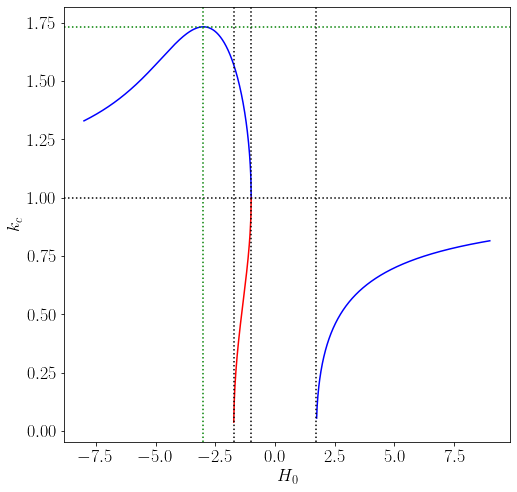

In [47]:
g_ratio =0
plt.figure(figsize=(8,8))  
kcrits_rangehs[g_ratio] = [kcrit(g_ratio,h) for h in fine_hs] #generate data
plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                  color='blue')
kcrits_rangehs_second={}
kcrits_rangehs_second[g_ratio] = [kcrit_second(g_ratio,h) for h in fine_hs] #generate data
plt.plot(fine_hs, [kc for kc in kcrits_rangehs_second[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                  color='red')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$k_c$")
#plt.ylim(0,2)
plt.axvline(-1, color='black', linestyle=':')
plt.axvline(-math.sqrt(3), color='black', linestyle=':')
plt.axvline(math.sqrt(3), color='black', linestyle=':')
plt.axhline(1, color='black', linestyle=':')
plt.axvline(-3, color='green', linestyle=':')
plt.axhline(math.sqrt(3), color='green', linestyle=':')

It looks like two solutions exist in the range H0=-1.73 to H0=-1.  The limit is actually $-1.73 = -\sqrt{3}$, the solution to $ 1-2g-4h - \sqrt{8(2g-3)+(-1+4h+2g)^2} ==0 , g = 1/2 h^2$ 

($g=2H_0^2$)

The other zero is $\sqrt{3}$, the solution to $ 1-2g-8h + \sqrt{8(2g-3)+(-1+8h+2g)^2} ==0 $ .

Also find out where the maximum is. DErivative of $k_c(H_0)$ =0 solved with mathematica: maximum is $H_0=-3$, $k_c = \sqrt{3} \approx1.73$ 

# 2. Minima by numerically integrating

For H_0 =0 : we are going to extract energy of the system for a range of k, kappa, a

In [14]:
a_s = np.arange(-.99, 1, .01)
ks = np.arange(0.005, 1.4, .01)

In [15]:
#generate (or load) curvature integral, surface area of the object for a range of k,a
if firsttime:
    curvenergy = {}
    for k in ks:
        curvenergya={}
        #print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.calc_bending_energy(amplitude=a)
            curvenergya[round(a,2)]=energy*k
            #note we are missing a factor of 2pi eveywhere in cylinder AND
            # these are total energies of an object of length 2pi/k, to get comparable energy per length
            # I here multiply by k/2pi
        curvenergy[round(k,4)]=curvenergya
    curvdata = pd.DataFrame(curvenergy)
    curvdata.to_csv("chapter2data/curvenergy_H0_tmp.csv")
else:
    curvdata=pd.read_csv("chapter2data/curvenergy_H0.csv", index_col=0)
#print(curvdata)

In [16]:
if firsttime:
    surfenergy = {}
    for k in ks:
        surfenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.evaluate_A_integral_0(amplitude=a)
            surfenergya[round(a,2)]=energy*k
        surfenergy[round(k,4)]=surfenergya
    #print(surfenergy)
    surfdata = pd.DataFrame(surfenergy)
    print(surfdata)
    surfdata.to_csv("chapter2data/surfenergy_H0_tmp.csv")
else:
    surfdata=pd.read_csv("chapter2data/surfenergy_H0.csv", index_col=0)
#print(surfdata)

In [17]:
#search each series A(a) (for each k)
#for the minimum surface area
if firsttime:
    minima_surf = {}
    for k in surfdata.columns:
        energy_vs_a = surfdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_surf[k]=({"a":min_a, "E":min_energy})
    #print(minima_surf)
    minima_surf_df = pd.DataFrame(minima_surf)
    minima_surf_df.to_csv("chapter2data/minima_surf_tmp.csv", header=True, index=True)
else:
    minima_surf_df=pd.read_csv("chapter2data/minima_surf.csv", index_col=0)
minima_surf_df

,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,0.095,...,1.305,1.315,1.325,1.335,1.345,1.355,1.365,1.375,1.385,1.395
a,0.990000,0.99000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.99000,0.99000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,5.147321,5.14749,5.147829,5.148336,5.149013,5.149859,5.150874,5.152057,5.15341,5.15493,...,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185


In [18]:
#same for curvature energy
if firsttime:
    minima_curv = {}
    for k in curvdata.columns:
        energy_vs_a = curvdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_curv[k]=({"a":min_a, "E":min_energy})
    #print(minima_curv)
    minima_curv_df=pd.DataFrame(minima_curv)
    minima_curv_df.to_csv("chapter2data/minima_curv_tmp.csv", index=True, header=True)
else:
    minima_curv_df=pd.read_csv("chapter2data/minima_curv.csv", index_col=0)
minima_curv_df

,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,0.095,...,1.305,1.315,1.325,1.335,1.345,1.355,1.365,1.375,1.385,1.395
a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,...,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185


Text(0, 0.5, '$|a|$')

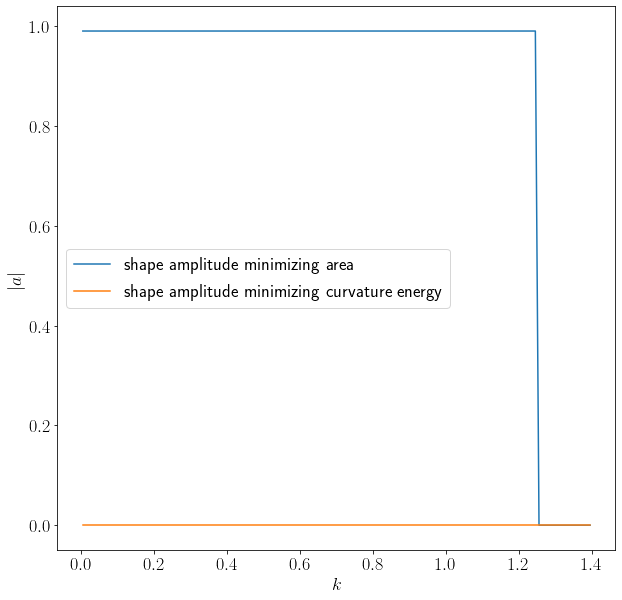

In [19]:
#print(minima_surf_df)
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.iloc[0,k]) for k in range(len(minima_surf_df.columns))], label="shape amplitude minimizing area")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.iloc[0,k]) for k in range(len(minima_curv_df.columns))],label="shape amplitude minimizing curvature energy")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|a|$")

Despite what we may know about the Plateau-Rayleigh instability being at k=1, this is correct; when looking
at the full energy functional the global minimum energy is at a shape $|a|\neq 0$ some way above $k=1$.
For $H_0=0$, curvature energy always least on flat cylinder as expected.

And the energy value $E(a_{min})$:

Text(0, 0.5, 'E')

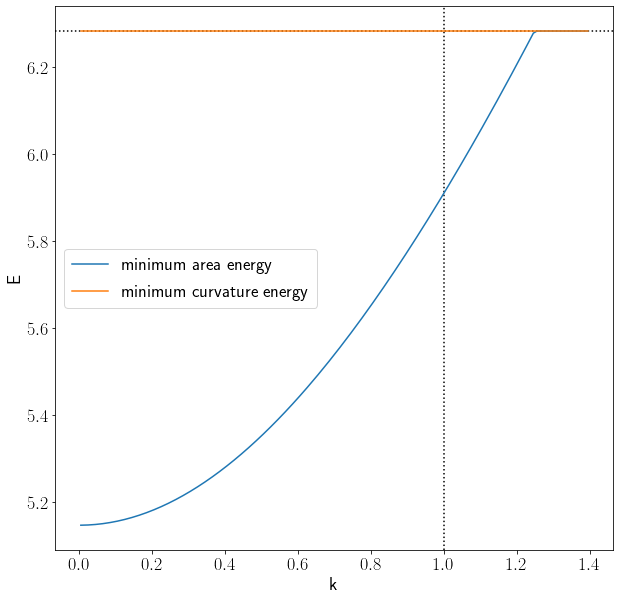

In [20]:
plt.axhline(math.pi*2, color='black', linestyle=':')
plt.axvline(1, color='black', linestyle=':')
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.loc['E',k]) for k in minima_surf_df.columns], label="minimum area energy")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.loc['E',k]) for k in minima_curv_df.columns],label="minimum curvature energy")
plt.legend()
plt.xlabel("k")
plt.ylabel("E")
#plt.ylim(0,10)

Area energy with $\gamma=1$; curvature energy with $\kappa=1$

Let's go through a range of ratios kappa:gamma and find the minimizing amplitude a and energy E at that minimum, for a range of ks

In [21]:
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    gamma=1
    kappas=np.arange(0,1,.01)
    for kappa in kappas:
        minima_total_as_kappa={}
        minima_total_Es_kappa={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_kappa[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_kappa[k]= min_energy
        minima_total_as[kappa]=minima_total_as_kappa
        minima_total_Es[kappa]=minima_total_Es_kappa
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_inkappaandk_tmp.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_inkappaandk_tmp.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_inkappaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_inkappaandk.csv", index_col=0, dtype=float)

<AxesSubplot:>

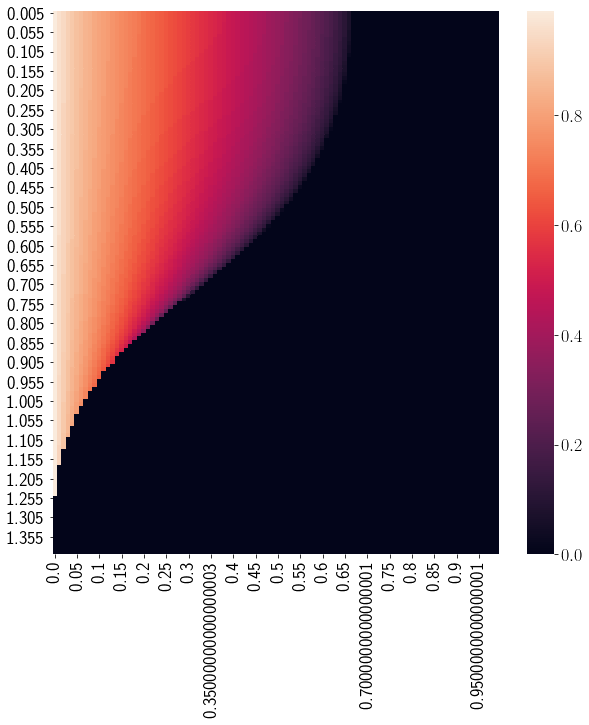

In [22]:
sb.heatmap(df_minima_total_as)

We also want an evenly spaced grid in the inverse paramterization, gamma/kappa

In [23]:
if firsttime:
    minima_total_as_g={}
    minima_total_Es_g={}
    kappa=1
    gammas=np.arange(1,5,.01)
    for gamma in gammas:
        minima_total_as_gamma={}
        minima_total_Es_gamma={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_gamma[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_gamma[k]= min_energy
        minima_total_as_g[gamma]=minima_total_as_gamma
        minima_total_Es_g[gamma]=minima_total_Es_gamma
    df_minima_total_as_g=pd.DataFrame(minima_total_as_g)
    df_minima_total_Es_g=pd.DataFrame(minima_total_Es_g)
    df_minima_total_as_g.to_csv("chapter2data/minimizing_a_ingammaandk_tmp.csv")
    df_minima_total_Es_g.to_csv("chapter2data/minimizing_E_ingammaandk_tmp.csv")
else:
    df_minima_total_as_g=pd.read_csv("chapter2data/minimizing_a_ingammaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es_g=pd.read_csv("chapter2data/minimizing_E_ingammaandk.csv", index_col=0, dtype=float)

<AxesSubplot:>

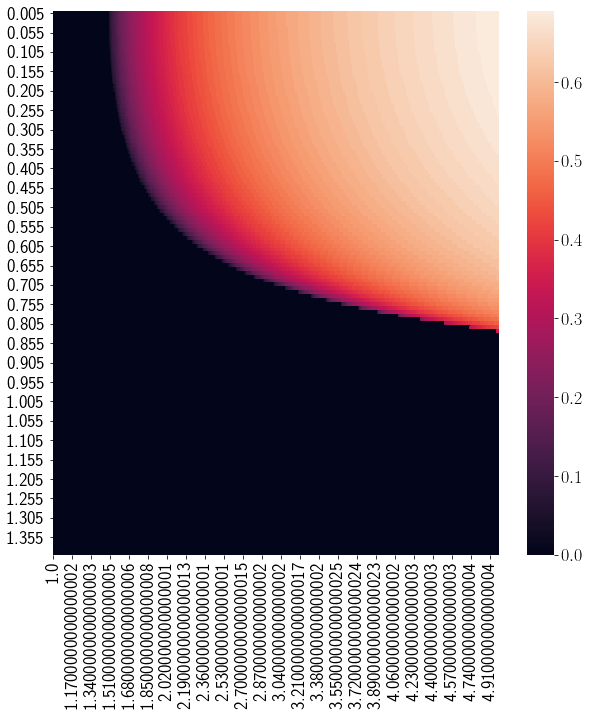

In [24]:
sb.heatmap(df_minima_total_as_g)


Let's make a pretty plot of both views with superimposed pertrubative limit k*

In [25]:
#the lines of section 1, shifted to overlay these grids
y_indices,x_indices = df_minima_total_as.shape
print(df_minima_total_as.shape)
#for lineplot 1 scale date from 0 to .95 to indices 0 to x_indices
lineplot_xs_1= [100*(1/g) for g,kc in zip(gs, kcrits_) if kc is not None]
#for lineplot 1 scale date from 1.395 to 0.005 to indices 0 to y_indices
lineplot_ys_1= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

lineplot_xs_2= [100*(g-1) for g,kc in zip(gs, kcrits_) if kc is not None]
lineplot_ys_2= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

(140, 100)


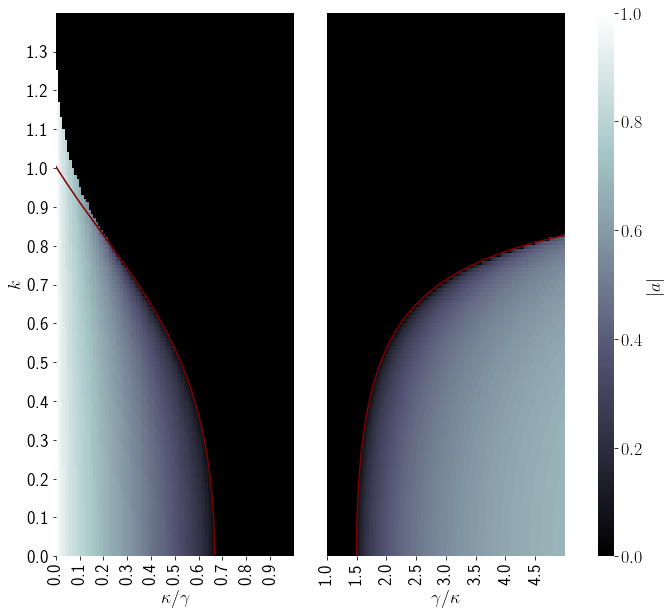

In [26]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1.2,1.2,0.08]}) #the last axis is for colorbar
#ax1.get_shared_y_axes().join(ax1,ax2)
ax1.plot(lineplot_xs_1, lineplot_ys_1, color='maroon')
ax1.set_ylim([0, 100*1.395])
ax1.set_xlim([0, 100*.99])
g1 = sb.heatmap(df_minima_total_as[::-1],cmap="bone",cbar=False,ax=ax1, vmax=1, vmin=0)
g1.set_ylabel(r'$k$')
g1.set_xlabel(r'$\kappa/\gamma$')
g1.set_xticks([n for n in range(0,100,10)])
g1.set_xticklabels([round(.01*n,3) for n in range(0,100,10)])
ax2.plot(lineplot_xs_2, lineplot_ys_2, color='maroon')
g2 = sb.heatmap(df_minima_total_as_g[::-1],cmap="bone",cbar=True, cbar_kws={'label':r'$|a|$'},
                ax=ax2, cbar_ax=axcb, vmax=1, vmin=0)
#g2.set_ylabel('k')
g2.set_xlabel(r'$\gamma/\kappa$')
g2.set_xticks([n for n in range(0,400,50)])
g2.set_xticklabels([round(1+.01*n,3) for n in range(0,400,50)])

g1.set_yticks([n+10 for n in range(0,140,10)])
g1.set_yticklabels([round(1.3-.01*n,3) for n in range(0,140,10)])
g2.set_yticks([])

plt.savefig("chapter2data/numerical_minima_tmp.png")
plt.show()

This plot shows how well the numerical minima in the energy E(a) match up with perturbative
prediction for limit of stability.
Pretty good, except for the overshoot at k=1, kappa=0.  
This is the region of metastability.  It can be explained by looking at surface area alone.

<AxesSubplot:>

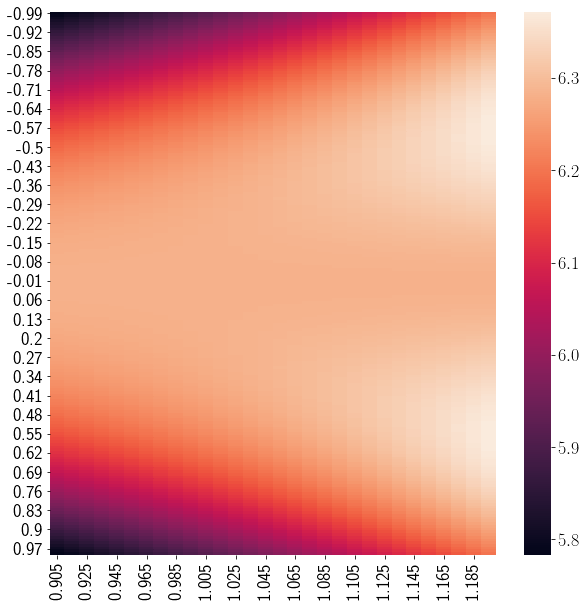

In [27]:
sb.heatmap(surfdata.iloc[:, 90:120])

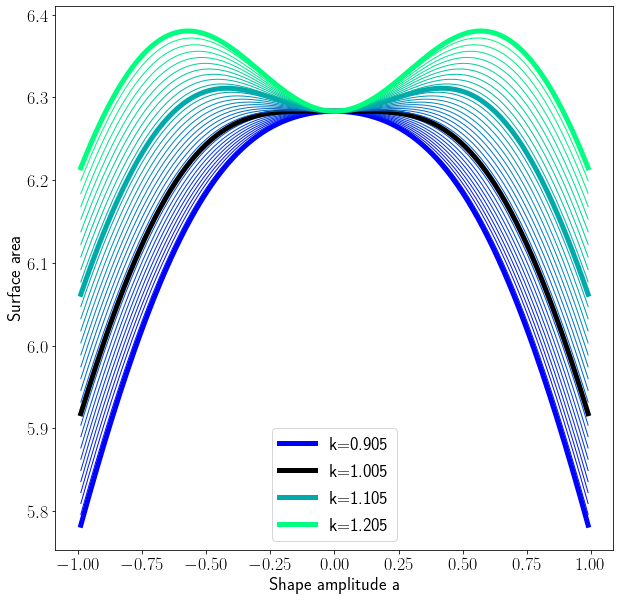

In [28]:
range1=90
range2=121
plt.figure(figsize=(10,10))   
cols = plt.cm.winter([(float(surfdata.columns[k_index])-float(surfdata.columns[range1]))/
                      (float(surfdata.columns[range2-1])-float(surfdata.columns[range1]))  
                      for k_index in range(90,121)])    
for index,k_index in enumerate(range(range1,range2)):
    k_line=surfdata.iloc[:,k_index]
    if k_index%10==0:
        if k_index==100:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color='black')
        else:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color=cols[index])
    else:
        plt.plot(k_line, linewidth=1,color=cols[index])
plt.xlabel("Shape amplitude a")
plt.ylabel("Surface area")
plt.legend()
#plt.ylim(6.2,6.3)
#plt.xlim(-.1, .1)
#plt.savefig("./chapter2data/surfarea_discrepancy_tmp.png")
plt.show()

We see that for $k \geq 1$, there is a local minimum at a=0, but the global minimum is at $a=1$.
Thus the two indicators of stability (curvature around a=0, searching for global minima) disagree.

## 2.2 spontaneous curvature

We also want plots of numerical results to match the spontaneous curvature results from section 1.
For a 3 chosen values gamma/kappa = 0, 1.5, 10, generate data a_min in a grid in k, H_0.



In [35]:
H0_s=np.arange(-8,8.0001,.1)
ks = np.arange(0.1, 2.3, .1) #have to go higher in k here
kappa=1
gammas=[0, 1.5, 10] #zero, critical, and a high surface tension
df_minima_total_as={} #dict of dataframes by gamma
df_minima_total_Es={}
names= {0:'0', 1.5: '1p5', 10: '10'} #for filenames

In [40]:
for gamma in gammas:
    if firsttime:
        # generate grids of energy minimizing value a and the minimum energy in
        # H0 x k.  This can take a long time with above fine grid spacing.
        minima_total_as={}
        minima_total_Es={}
        for H0 in H0_s:
            print(H0)
            minima_total_as_H0={}
            minima_total_Es_H0={}
            for k in ks:
                #there should be a better way than setting up a new object, with attached
                # MetropolisEngine,  each time
                # ... like resetting its values
                cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
                curvenergya={}
                for a in a_s:
                    energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
                    curvenergya[round(a,2)]=energy*k
                total_energy_vs_a = pd.Series(curvenergya)#turn dict to series
                min_a = total_energy_vs_a.idxmin()
                min_energy = total_energy_vs_a[min_a]
                minima_total_as_H0[round(k,5)]=abs(min_a)
                minima_total_Es_H0[round(k,5)]= min_energy
            minima_total_as[round(H0,3)]=minima_total_as_H0
            minima_total_Es[round(H0,3)]=minima_total_Es_H0
        df_minima_total_as[gamma]=pd.DataFrame(minima_total_as)
        df_minima_total_Es[gamma]=pd.DataFrame(minima_total_Es)
        df_minima_total_as[gamma].to_csv("chapter2data/minimizing_a_H0_gamma"+names[gamma]+"_tmp.csv")
        df_minima_total_Es[gamma].to_csv("chapter2data/minimizing_E_H0_gamma"+names[gamma]+"_tmp.csv")
    else:
        df_minima_total_as[gamma]=pd.read_csv("chapter2data/minimizing_a_H0_gamma"+names[gamma]+".csv", index_col=0, dtype=float)
        df_minima_total_Es[gamma]=pd.read_csv("chapter2data/minimizing_E_H0_gamma"+names[gamma]+".csv", index_col=0, dtype=float)

In particular examine the $\gamma_0 = 0$ case

(161, 22)


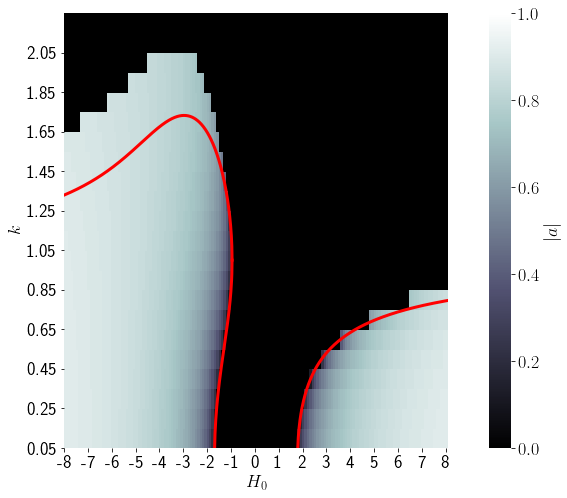

In [41]:
xfactor, yfactor = df_minima_total_as[0].transpose().shape
print((xfactor, yfactor))
xfactor/=16.0
yfactor/=2.2
offsetx=-8
offsety=.05
fine_hs_scaled = [(h-offsetx)*xfactor for h in fine_hs]
kcrits_rangehs_scaled={}
kcrits_rangehs_second_scaled={}
for g in [0,1.5,10]:
    kcrits_rangehs_scaled[g] = [(kc-offsety)*yfactor for kc in kcrits_rangehs[g]]
kcrits_rangehs_second_scaled[0]=[(kc-offsety)*yfactor for kc in kcrits_rangehs_second[0]]


f,(ax1,axcb) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1.4, 0.08]}, figsize=(8,8)) #the last axis is for colorbar
#ax1.get_shared_y_axes().join(ax1,ax2)
ax1.plot(fine_hs_scaled, kcrits_rangehs_scaled[0], color='red',linewidth=3)
ax1.plot(fine_hs_scaled, kcrits_rangehs_second_scaled[0], color='red',linewidth=3)
g1 = sb.heatmap(df_minima_total_as[0],cmap="bone",cbar=True,ax=ax1, vmax=1, vmin=0,cbar_kws={'label':r'$|a|$'},
                cbar_ax=axcb,)
g1.set_ylabel(r'$k$')
g1.set_xlabel(r'$H_0$')
g1.set_xticks([n for n in range(0,161,10)])
g1.set_xticklabels([round(n/10-8) for n in range(0,161,10)], rotation = 0)
g1.set_yticks([n for n in range(0,22,2)])
g1.set_yticklabels([round(n/10+.05,5) for n in range(0,22,2)])
ax1.invert_yaxis()


plt.savefig("chapter2data/numerical_H0_g0_tmp.png")
plt.show()

Yes this is plotted correctly: The line meets the left frame at $\sim 1.35$ and (look like exactly) $.8$ on the right. The maximum is at $\sqrt{3} = 1.73$.

The numerical region goes higher: it's the metastability overshoot.

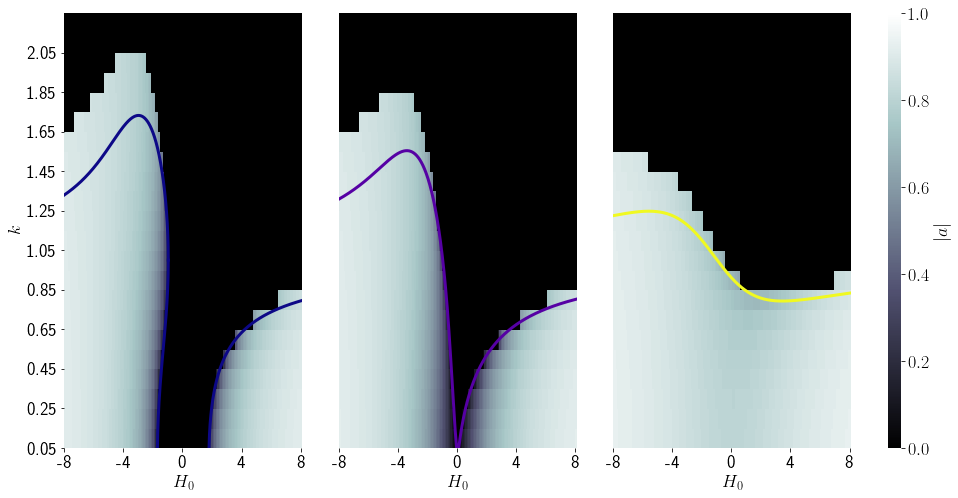

In [44]:
 
f,(ax1,ax2, ax3, axcb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1.4,1.4,1.4, 0.08]}, figsize=(15,8)) #the last axis is for colorbar
#ax1.get_shared_y_axes().join(ax1,ax2)
ax1.plot(fine_hs_scaled, kcrits_rangehs_scaled[0], color=g_ratio_colors[0],linewidth=3)
ax1.plot(fine_hs_scaled, kcrits_rangehs_second_scaled[0], color=g_ratio_colors[0],linewidth=3)
#ax1.set_ylim([0, 100*1.395])
#ax1.set_xlim([0, 100*.99])
g1 = sb.heatmap(df_minima_total_as[0],cmap="bone",cbar=False,ax=ax1, vmax=1, vmin=0)
g1.set_ylabel(r'$k$')
g1.set_xlabel(r'$H_0$')
g1.set_xticks([n for n in range(0,161,40)])
g1.set_xticklabels([round(n/10-8) for n in range(0,161,40)], rotation = 0)
g1.set_yticks([n for n in range(0,22,2)])
g1.set_yticklabels([round(n/10+.05,5) for n in range(0,22,2)])
ax1.invert_yaxis()

ax2.plot(fine_hs_scaled, kcrits_rangehs_scaled[1.5], color=g_ratio_colors[1.5],linewidth=3)
g2 = sb.heatmap(df_minima_total_as[1.5],cmap="bone",cbar=False, 
                ax=ax2, cbar_ax=axcb, vmax=1, vmin=0)
ax2.invert_yaxis()
g2.set_xlabel(r'$H_0$')
g2.set_xticks([n for n in range(0,161,40)])
g2.set_xticks([n for n in range(0,161,40)])
g2.set_xticklabels([round(n/10-8) for n in range(0,161,40)], rotation = 0)
#g2.set_xticklabels([round(1+.01*n,3) for n in range(0,400,50)])
g2.set_yticks([])

g3 = sb.heatmap(df_minima_total_as[10],cmap="bone",cbar=True, cbar_kws={'label':r'$|a|$'},
                ax=ax3, cbar_ax=axcb, vmax=1, vmin=0)
ax3.plot(fine_hs_scaled, kcrits_rangehs_scaled[10], color=g_ratio_colors[10], linewidth=3)
ax3.invert_yaxis()
g3.set_xlabel(r'$H_0$')
g3.set_xticks([n for n in range(0,161,40)])
g3.set_xticklabels([round(n/10-8) for n in range(0,161,40)], rotation = 0)
g3.set_yticks([])

plt.savefig("chapter2data/numerical_H0_tmp.png")
plt.show()

### What order of transition?
Plot the energy landscape around there

In [ ]:
gamma=0
H0 = -.6
for k in np.arange(.5, 1.4, .05):
    cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
    curvenergya={}
    for a in a_s:
        energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
        curvenergya[round(a,2)]=energy*k
    plt.plot(curvenergya.keys(), curvenergya.values(), label=str(round(k,3)))
plt.legend()
plt.ylim(.4,1)
plt.xlim(-.6,.6)

In [ ]:
gamma=0
H0 = -.5
for k in np.arange(.5, 1.4, .05):
    cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
    curvenergya={}
    for a in a_s:
        energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
        curvenergya[round(a,2)]=energy*k
    plt.plot(curvenergya.keys(), curvenergya.values(), label=str(round(k,3)))
plt.legend()
plt.ylim(0,4)
plt.xlim(-.6,.6)

In [ ]:
gamma=0
k = 1
for H0 in np.arange(-1.2, -.2, .05):
    cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
    curvenergya={}
    for a in a_s:
        energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
        curvenergya[round(a,2)]=energy*k
    plt.plot(curvenergya.keys(), curvenergya.values(), label=str(round(H0,3)))
plt.legend()
#plt.ylim(0,15)
#plt.xlim(-.6,.6)

Still need to multiply this by a factor cn^2|sqrt(alpha/u)|^2 (can be taken out of the integral) for the specific field